# Analysis

## Given Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
from pyspark_dist_explore import hist
import shutil

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/10/12 11:25:20 WARN Utils: Your hostname, DESKTOP-LNDD2A2 resolves to a loopback address: 127.0.1.1; using 172.31.195.31 instead (on interface eth0)
22/10/12 11:25:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/12 11:25:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/12 11:25:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Load the required datasets
sdf = spark.read.parquet("../data/curated/mergedftemp.parquet/")
merchantdf = spark.read.parquet("../data/curated/merchantdf.parquet/")
userdf = spark.read.parquet("../data/tables/consumer_user_details.parquet")
transactiondf = spark.read.parquet("../data/curated/transactiondf.parquet/")

## Revenue Band

  revenue_band  count
0            a   1602
1            b   1351
2            c    922
3            d     98
4            e     53


<AxesSubplot:title={'center':'Distribution of Merchant Revenue Bands'}, ylabel='count'>

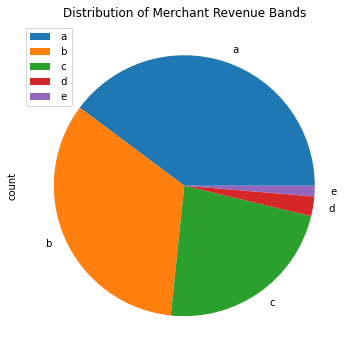

In [3]:
# Get the distribution of merchant revenue bands
print(merchantdf.groupby('revenue_band').count().sort('revenue_band').toPandas())
merchantdf.groupby('revenue_band').count().sort('revenue_band').toPandas().set_index('revenue_band')\
.plot(kind='pie', y='count', figsize=(9, 6), legend=True, title="Distribution of Merchant Revenue Bands")

  revenue_band    count
0            a  6111561
1            b  3921368
2            c  3324800
3            d   136838
4            e   120108


<AxesSubplot:title={'center':'Distribution of Transaction Revenue Bands'}, ylabel='count'>

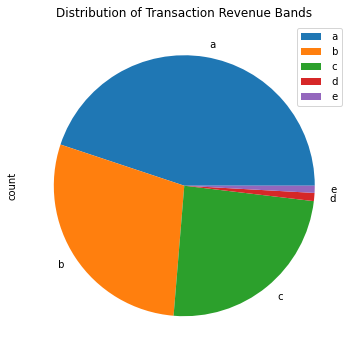

In [4]:
# Repeat steps above, but instead for distribution of transaction revenue bands. 
# By comparing to chart above, we can observe if merchants with certain revenue bands
# are associated with more/less transactions
print(sdf.groupby('revenue_band').count().sort('revenue_band').toPandas())
sdf.groupby('revenue_band').count().sort('revenue_band').toPandas().set_index('revenue_band')\
.plot(kind='pie', y='count', figsize=(9, 6), legend=True, title="Distribution of Transaction Revenue Bands")

Despite a rather involved splitting process of the tags field, we do not see any invalid entries in the revenue band field. The majority of revenue bands lie between a-c, with d and e revenue bands clearly being reserved for the most extreme merchants. Overall the number of merchants decreases as you reach higher revenue bands.

Revenue band a is shown to be somewhat overrepresented in the transaction distribution as compared to the merchant distribution, indicating it is likely merchants of this revenue band are associated with a higher number of transactions. The opposite can be said of revenue band b, with the remaining bands not showing any significant differences. 

## Take Rate

Text(0.5, 1.0, 'Frequency of Take Rates Among Merchants')

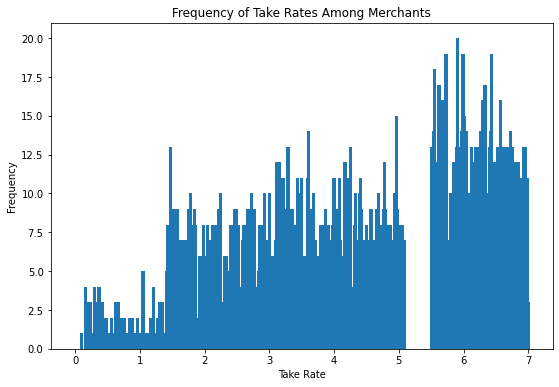

In [7]:
# All take rates in range 0-7 (in increments of 0.01) are given a default value 0.
takerate_df = pd.DataFrame({"take_rate":np.arange(0, 7.01, 0.01), "count": 0})\
.set_index("take_rate")

# Overwrite counts of take rates with at least 1 occurance
takerate_df['count'] = merchantdf.groupby('take_rate').count().sort('take_rate')\
.toPandas().astype({'take_rate':'float'}).set_index('take_rate')
takerate_df = takerate_df.fillna(0)

# Create bar graph of take rate frequencies
fig, ax = plt.subplots(figsize=(9,6))
ax.bar(takerate_df.index, takerate_df['count'], width=0.05)
plt.xlabel('Take Rate')
plt.ylabel('Frequency')
plt.title('Frequency of Take Rates Among Merchants')

Text(0.5, 1.0, 'Frequency of Take Rates Among Transactions')

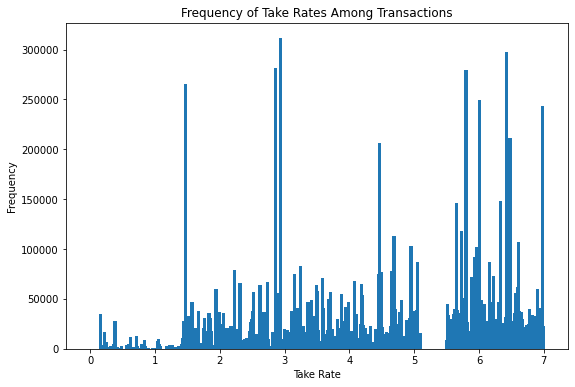

In [9]:
## Again, repeat the above at a transaction level.
takerate_df = pd.DataFrame({"take_rate":np.arange(0, 7.01, 0.01), "count": 0})\
.set_index("take_rate")
takerate_df['count'] = sdf.groupby('take_rate').count().sort('take_rate')\
.toPandas().astype({'take_rate':'float'}).set_index('take_rate')
takerate_df = takerate_df.fillna(0)

fig, ax = plt.subplots(figsize=(9,6))
ax.bar(takerate_df.index, takerate_df['count'], width=0.05)
plt.xlabel('Take Rate')
plt.ylabel('Frequency')
plt.title('Frequency of Take Rates Among Transactions')

There appears to be 3 distinct 'groups' in the distribution of take rate. The first comprising of very few merchants, which have a take rate between 0% and just over 1%. Rather logically, no merchants have a take rate of 0, and we don't see any nonsensical take rates either, such as negative take rates. 

The second group composes of merchants with a take take of just over 1% to roughly 5%. The number of merchants in this group appears to have jumped significantly as compared to the previous group.

We notice a rather interesting pattern in that no merchants appear to have a take rate between just over 5% and roughly 5.5%. The exact reason for this is unclear, but it was though that this could have something to do with the method used to determine a merchant's take rate? When also considering that there appears to be a low, medium and high group of take rates, finding out more about how these take rates are determined may be of further interest.

The final group contains merchants between 5.5% take rate, and what appears to be the maximum possible take rate of 7%.

Finally, inside of each of the 3 groups, take rate appears to be for the most part uniformally distributed. On a transactional level, we do observe many random spikes in frequency in groups, however this appears to be somewhat random for the most part. Again however, it may be of interest to learn more about what determines the take rate of a merchant, and specifically once a group is decided, how it is then decided where in this group this merchant will be.

## Tags

In [12]:
# Merchant level
merchantdf.groupby('tags').count().sort('tags').show(100, truncate=False)

# Transaction level
sdf.groupby('tags').count().sort('tags').show(100, truncate=False)

+-------------------------------------------------------------------------------------+-----+
|tags                                                                                 |count|
+-------------------------------------------------------------------------------------+-----+
|antique shops - sales, repairs, and restoration services                             |129  |
|art dealers and galleries                                                            |112  |
|artist supply and craft shops                                                        |193  |
|bicycle shops - sales and service                                                    |170  |
|books, periodicals, and newspapers                                                   |164  |
|cable, satellite, and other pay television and radio services                        |175  |
|computer programming , data processing, and integrated systems design services       |191  |
|computers, computer peripheral equipment, and software     

+-------------------------------------------------------------------------------------+-------+
|tags                                                                                 |count  |
+-------------------------------------------------------------------------------------+-------+
|antique shops - sales, repairs, and restoration services                             |178718 |
|art dealers and galleries                                                            |21218  |
|artist supply and craft shops                                                        |472178 |
|bicycle shops - sales and service                                                    |224735 |
|books, periodicals, and newspapers                                                   |394616 |
|cable, satellite, and other pay television and radio services                        |957060 |
|computer programming , data processing, and integrated systems design services       |518596 |
|computers, computer peripheral equipmen

After cleaning up the field, we find there are actually only 25 different unique values for tags, with these being fairly evenly distributed amongst merchants. This is a fairly interesting finding, since it was at first thought that this field was unique to each vendor, particularly given its nature as being a field entered manually.

The maximum count shows 195 merchants with tag 'digital goods: books, movies, music' and minimum count shows 91 merchants with tag 'jewelry, watch, clock and silverware shops'.

Viewing the occurences of these tags at a transactional level, it is revealed that certain tags are clearly associated with more/less frequent transactions. For example, 'jewelry, watch, clock, and silverware shops' merchants are seen to have by far the least frequent amount of transactions as opposed to 'tent and awning shops' which have the most.

# Consumer ID/User ID

In [13]:
# Confirm all consumer ids in this table are unique
print(userdf.groupby('consumer_id').count().sort(desc('count')))
print(userdf.groupby('consumer_id').count().sort(desc('count')).count())

+-----------+-----+
|consumer_id|count|
+-----------+-----+
|    1174371|    1|
|     921339|    1|
|     612215|    1|
|    1493354|    1|
|     742966|    1|
|     567201|    1|
|     374960|    1|
|     653529|    1|
|     967705|    1|
|    1258545|    1|
|    1246796|    1|
|     287607|    1|
|     363321|    1|
|    1277685|    1|
|     617323|    1|
|    1371766|    1|
|      88291|    1|
|     295586|    1|
|      75264|    1|
|     582897|    1|
+-----------+-----+
only showing top 20 rows



499999


In [14]:
# Confirm all user ids in this table are unique
print(userdf.groupby('user_id').count().sort(desc('count')))
print(userdf.groupby('user_id').count().sort(desc('count')).count())

+-------+-----+
|user_id|count|
+-------+-----+
|     41|    1|
|    499|    1|
|    907|    1|
|   1085|    1|
|   1114|    1|
|   1273|    1|
|   1473|    1|
|   1574|    1|
|   1689|    1|
|   1695|    1|
|   1716|    1|
|   1783|    1|
|   2051|    1|
|   2171|    1|
|   2474|    1|
|   2556|    1|
|   2825|    1|
|   2935|    1|
|   3017|    1|
|   3108|    1|
+-------+-----+
only showing top 20 rows

499999


In [17]:
# Check which user ids are actually used in at least one transaction
print(transactiondf.groupby('user_id').count().sort('count'))
print(transactiondf.groupby('user_id').count().sort('user_id').count())

+-------+-----+
|user_id|count|
+-------+-----+
|  12794|  568|
|  10243|  568|
|  12472|  568|
|   8222|  569|
|  22068|  569|
|  19300|  569|
|  16172|  569|
|  11002|  569|
|   6170|  569|
|  23016|  569|
|  13584|  569|
|   3807|  569|
|  14835|  569|
|   9633|  569|
|  14961|  569|
|   8252|  569|
|   4875|  569|
|   1182|  569|
|  21054|  569|
|   4195|  569|
+-------+-----+
only showing top 20 rows



24081


There are no problems caused by joining this table (even if its need is questionable in the first place). This table simply maps all user_ids from 0-499999 to some consumer_id. 

However, in the transactions given only user_ids up to 24,081 actually have at least 1 valid transaction in the dataset, meaning many of these mappings appear to go unused.

## Invalid Transactions

In [18]:
# Since all tables are joined to the transactions, we can observe how many rows were lost in the
# joining process.
print(transactiondf.count() - sdf.count())

580830


By simply joining all tables to the transaction table via the relevant foreign keys, any transaction which can't be joined for some reason will be discarded. As seen above, this would mean that 580,830 transactions would be simply discarded without our knowledge.

In [19]:
# Get dataframe of all transactions that were dropped
dropped_transactions = transactiondf.join(sdf, 'order_id', "leftanti")
dropped_transactions.count()

580830

In [20]:
dropped_transactions

order_id,user_id,merchant_abn,dollar_value,order_datetime
00008196-1d92-46a...,23551,75342681786,43.50358603652356,2022-09-01
000334fe-7ab8-4e7...,2438,11240426404,161.65965550330247,2021-05-01
0003ac7a-b4ae-4df...,3858,32234779638,72.16713166603107,2022-03-02
0003bf66-dd63-44f...,5372,32234779638,28.867172510909565,2022-09-30
0003f77c-e7a4-444...,5086,66600007969,1944.1907298666279,2021-10-10
00046cd3-6304-48b...,8416,29566626791,59.21022532355943,2022-02-20
0005de75-8578-444...,2248,20562405782,114.94675596872872,2022-02-06
000a2eff-46fc-41e...,1758,28898261035,8.087295024445776,2022-07-04
0013e0fb-71c4-427...,10785,29323795999,73.16932434536905,2021-10-02
00156de7-9b79-4d6...,14751,87802246756,32.62876297473494,2022-02-28


In [21]:
# Were any customers ignored completely because of these transactions?
print(dropped_transactions.filter(dropped_transactions.user_id > 24081))

+--------+-------+------------+------------+--------------+
|order_id|user_id|merchant_abn|dollar_value|order_datetime|
+--------+-------+------------+------------+--------------+
+--------+-------+------------+------------+--------------+



All transactions appear to have a valid user id, with no new ids introduced exclusively in these dropped transactions.

In [23]:
# Now test merchants, how many unique merchants are in these transactions?
print(dropped_transactions.groupby('merchant_abn').count().count())
print(dropped_transactions.groupby('merchant_abn').count().sort('merchant_abn'))

# Try and join with just merchants
print(dropped_transactions.join(merchantdf, "merchant_abn"))

396


+------------+-----+
|merchant_abn|count|
+------------+-----+
| 10672322914|  107|
| 11029341140|   18|
| 11137507330| 1988|
| 11240426404|54716|
| 11358147682|   83|
| 11400713351|   64|
| 11839682616|  746|
| 12959561070|    2|
| 13129485817|   15|
| 13177076095|  330|
| 13226823813|  574|
| 13289167958|   11|
| 13494073581|   19|
| 13868849576|  863|
| 14827550074| 1439|
| 15058508937|   38|
| 15073921424|   15|
| 15699401518|  251|
| 15862090061|  242|
| 16496390781|   66|
+------------+-----+
only showing top 20 rows



+------------+--------+-------+------------+--------------+------------+----+---------+------------+
|merchant_abn|order_id|user_id|dollar_value|order_datetime|company_name|tags|take_rate|revenue_band|
+------------+--------+-------+------------+--------------+------------+----+---------+------------+
+------------+--------+-------+------------+--------------+------------+----+---------+------------+



Therefore, all invalid transactions are shown to be dropped because they do not have a valid merchant_abn to link to. In total, there are 396 unique merchant abns that are listed in these transactions, that do not appear in the merchant dataset. one might want to consider all these merchants as if they shared the same tag (i.e. a special tag category 'missing'), however just simply removing transactions from a merchant we have no information on would also seem sensible, which we are already doing when joining.

## Merchants

In [24]:
# Now explore the opposite, are there any merchants we have info on that do not have at least one valid transaction?
no_transaction_merchants = merchantdf.join(sdf.groupby('merchant_abn').count(), 'merchant_abn', "leftanti")
no_transaction_merchants

merchant_abn,company_name,tags,take_rate,revenue_band


Every merchant listed in the respective dataset has at least one valid transaction. 

## Dollar Value

In [25]:
# Check if there are any extreme dollar values (such as a negative number)
print(sdf.agg(min("dollar_value"), max("dollar_value")))

+--------------------+------------------+
|   min(dollar_value)| max(dollar_value)|
+--------------------+------------------+
|9.756658099412162E-8|105193.88578925544|
+--------------------+------------------+



There clearly appears to be some nonsensical transaction dollar value amounts. Clearly, it does not make sense for a transaction to be less than a cent. Therefore, any transactions with dollar values less than a cent are removed. 

One could likely set this threshold higher, but since we have no knowledge of the product base for merchants, we stuck to this relatively safe threshold.

In [29]:
# Check how many transactions have dollar value less than a cent.
print(sdf.count())
sdf2 = sdf.filter(sdf.dollar_value > 0.01)
print(sdf2.count())

22/10/12 12:22:44 ERROR Executor: Exception in task 3.0 in stage 280.0 (TID 548)
java.io.FileNotFoundException: 
File file:/mnt/c/Users/Jai_b/Downloads/Uni/Year 3/Applied Data Science/generic-buy-now-pay-later-project-group-35/data/curated/mergedftemp.parquet/part-00013-a76c6f43-3477-4626-8645-b63dd5c4c846-c000.snappy.parquet does not exist

It is possible the underlying files have been updated. You can explicitly invalidate
the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by
recreating the Dataset/DataFrame involved.
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:648)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:212)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:270)
	at org.apache.spark.sql.execution.datasources.FileScanRD

Py4JJavaError: An error occurred while calling o38.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 280.0 failed 1 times, most recent failure: Lost task 3.0 in stage 280.0 (TID 548) (172.31.195.31 executor driver): java.io.FileNotFoundException: 
File file:/mnt/c/Users/Jai_b/Downloads/Uni/Year 3/Applied Data Science/generic-buy-now-pay-later-project-group-35/data/curated/mergedftemp.parquet/part-00013-a76c6f43-3477-4626-8645-b63dd5c4c846-c000.snappy.parquet does not exist

It is possible the underlying files have been updated. You can explicitly invalidate
the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by
recreating the Dataset/DataFrame involved.
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:648)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:212)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:270)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:116)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:553)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.io.FileNotFoundException: 
File file:/mnt/c/Users/Jai_b/Downloads/Uni/Year 3/Applied Data Science/generic-buy-now-pay-later-project-group-35/data/curated/mergedftemp.parquet/part-00013-a76c6f43-3477-4626-8645-b63dd5c4c846-c000.snappy.parquet does not exist

It is possible the underlying files have been updated. You can explicitly invalidate
the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by
recreating the Dataset/DataFrame involved.
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:648)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:212)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:270)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:116)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:553)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)


We therefore remove 1014 transactions from the dataset.

In [27]:
sdf2.write.mode("overwrite").parquet('../data/curated/mergedf.parquet')

In [28]:
shutil.rmtree('../data/curated/mergedftemp.parquet')